# Revised Magnitude tests (With super large models)
What exactly does magnitude correlate in word embeddings from Large Language Models? Can we find markers of complexity in differences between clearly defined groups of English language words?

I will compare dialects (British-English, American-English), plurals (wife, wives), and Oxford Corpus frequencies as a part of attempting to investigate these issues.

Whats new in XXL: flan-t5-xxl (11b), and no OPT.

In [2]:
import os
import torch
import random
import numpy as np

import sentencepiece    # necessary for proper t5 init.
from transformers import T5Tokenizer, T5EncoderModel, GPT2Tokenizer, OPTModel

from sklearn.metrics.pairwise import cosine_similarity

## Load Models

### Vocab

In [3]:
vocab = []
with open('./vocab/expanded_vocab.txt', 'r') as f:
    for line in f:
        vocab.append(line.strip())

len(vocab)

5124

In [4]:
top_50 = []
with open('./vocab/top_50.txt', 'r') as f:
    for line in f:
        top_50.append(line.strip())

bottom_50 = []
with open('./vocab/bottom_50.txt', 'r') as f:
    for line in f:
        bottom_50.append(line.strip())

### T5

In [6]:
t5_tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-xxl', cache_dir='/scratch/mbarlow6/.cache')
model_t5_raw = T5EncoderModel.from_pretrained('google/flan-t5-xxl', cache_dir='/scratch/mbarlow6/.cache')

Some weights of the model checkpoint at google/flan-t5-xxl were not used when initializing T5EncoderModel: ['decoder.block.7.layer.1.layer_norm.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.14.layer.1.EncDecAttention.k.weight', 'decoder.block.8.layer.1.layer_norm.weight', 'decoder.block.17.layer.0.SelfAttention.k.weight', 'decoder.block.14.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.19.layer.2.layer_norm.weight', 'decoder.block.12.layer.0.layer_norm.weight', 'decoder.block.21.layer.1.EncDecAttention.v.weight', 'decoder.block.10.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.1.EncDecAttention.k.weight', 'decoder.block.21.layer.0.SelfAttention.v.weight', 'decoder.block.3.layer.1.layer_norm.weight', 'decoder.block.9.layer.0.layer_norm.weight', 'decoder.block.10.layer.0.layer_norm.weight', 'decoder.block.17.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.17.layer.2.layer_norm.weight', 'decoder.block.6.layer.2.DenseReluD

In [7]:
t5_embeds = []
with open('./t5/flan_t5_11b.txt', 'r') as f:
    for line in f:
        t5_embeds.append([float(x) for x in line.strip().split()])
model_t5 = dict(zip(vocab, t5_embeds))

In [8]:
def t5_embed(text, tokenizer=t5_tokenizer, model=model_t5_raw, debug=False):
    inputs = tokenizer(text, return_tensors='pt')
    if debug:
        print('Tokens Requested:')
        print(tokenizer.batch_decode(inputs.input_ids[0]))
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.squeeze(outputs.last_hidden_state, dim=0)
    return np.array(torch.mean(embeddings, dim=0))

## Helper Functions

In [19]:
def positive(words, model='opt'):
    """
    Args:
        words: iterable
        model: 'opt' or 't5'
    Returns:
        Positive (summed vectors) of word embeddings of a given list of words from the specified model. Defaults to OPT-1.3b.
    """
    if isinstance(words, str):
        print(f"You requested the positive of the string \"{words}\". Did you mean [\"{words}\"]?")

    out = 0
    for token in words:
        word = str(token)
        if word in model_t5:
            ex = model_t5[word]
        else:
            ex = t5_embed(word)
            model_t5[word] = ex
        

        # construct positive
        if isinstance(out, int):
            out = np.array(ex).reshape(1, -1)
        else:
            out += np.array(ex).reshape(1, -1)
            
    return out if not isinstance(out, int) else np.array([])

In [10]:
def sum_complexity(word, vec=False, model='opt'):
    """
    Args:
        word: iterable, string, or vector   -> embedding to be summed.
        vec: bool                           -> True if word is already vector.
        model: str                          -> 'opt' or 't5'
    Returns:
        Float score of the sum of the absolute value of each datapoint in the embedding.
    """
    phrase = word
    if not vec:
        if isinstance(word, str):
            phrase = positive([word], model=model)
        else:
            phrase = positive(word, model=model)
    
    modified = [abs(float(x)) for x in phrase[0]]
    return sum(modified)
    

In [11]:
def simple_sum(word, vec=False, model='opt'):
    """
    Args:
        word: iterable, string, or vector   -> embedding to be summed.
        vec: bool                           -> True if word is already vector.
        model: str                          -> 'opt' or 't5'
    Returns:
        Float score of the simple sum of each datapoint in the embedding.
    """
    phrase = word
    if not vec:
        if isinstance(word, str):
            phrase = positive([word], model=model)
        else:
            phrase = positive(word, model=model)
    
    modified = [float(x) for x in phrase[0]]
    return sum(modified)

In [12]:
def similar_dims(w1, w2, n=10):
    # performs dimension-wise comparison of two vectors of EQUAL size
    # returns the top and bottom n scores.
    sims = []
    for i in range(w1.shape[1]):
        x = w1[0][i]
        y = w2[0][i]
        sims.append((i, (x, y), abs(x-y)))
    sims.sort(key=lambda x: x[2])
    return sims[:n], sims[len(sims)-n:]

In [13]:
def sig_dim(word, topn=5, model='opt'):
    """
    Args:
        word: str   target word to evaluate
        topn: int   number of dimesions to return
        model: str  'opt' or 't5'. Defaults to 'opt'.
    Returns:
        Indices of the n largest dimensions in the vector embedding of word in model.
    """
    p = positive([word], model=model)
    helper = []
    for i in range(len(p[0])):
        helper.append((i, p[0][i]))
    helper.sort(key=lambda x: abs(x[1]), reverse=True)
    return helper[:topn]

In [14]:
def percent_diff(word1, word2, model='opt'):
    w1c = sum_complexity(word1, model=model)
    w2c = sum_complexity(word2, model=model)

    return (w1c, w2c, ((w1c / w2c) - 1) * 100)

In [15]:
# @cache
def avg_diff(n, word1=None, corpus=top_50, model='opt'):
    if n > len(corpus):
        n = len(corpus)
    srcwords = [word1] * n if not word1 is None else random.sample(corpus, k=n)
    destwords = random.sample(corpus, k=n)

    history = []
    sm = 0

    for word1 in srcwords:
        for word2 in destwords:
            if word1 == word2:
                continue
            ans = percent_diff(word1, word2, model)
            history.append(ans)
            sm += ans[2]
            
    history.sort(key=lambda x: abs(x[2]), reverse=True)
    av = sm / (n ** 2)
    return av, history
    

In [16]:
def compare_mag(words):
    """
    Wrapper for direct comparison using our magnitude tests
    """
    if isinstance(words, str):
        words = [words] 
    for word in words:
        print(word)
        print(f"\t\tT5")
        print(f"Simple Sum:\t{simple_sum(word, model='t5')}")
        print(f"Absolute Sum:\t{sum_complexity(word, model='t5')}")
        print(f"Signif. Dims:\tT5:  {sig_dim(word, model='t5')}")
        print('--------------------------------------------------------------\n')
        

In [23]:
def compare_mag(words, n=100):
    if isinstance(words, str):
        words = [words] 
    print("Word pair\t\tT5")
    for i in range(len(words)-1):
        w1 = words[i]
        for j in range(i+1, len(words)):
            w2 = words[j]
            comp_opt = percent_diff(w1, w2)
            comp_t5 = percent_diff(w1, w2, model='t5')
            print(f"{w1} -> {w2}\t\t{'{:.4f}'.format(comp_t5[2])}%")
    print()
    for word in words:
        rand100_t5, _ = avg_diff(n, corpus=vocab, word1=word, model='t5')

        t50_t5, _ = avg_diff(50, corpus=top_50, word1=word, model='t5')

        b50_t5, _ = avg_diff(50, corpus=bottom_50, word1=word, model='t5')

        print(f"{word} -> B50\t\t{'{:.4f}'.format(b50_t5)}%")
        print(f"{word} -> T50\t\t{'{:.4f}'.format(t50_t5)}%")
        print(f"{word} -> Rand100\t{'{:.4f}'.format(rand100_t5)}%")
        print()
        

## Run Tests

In plain english, the below tests explain relations like "The magnitude of 'color' is 16% larger than 'colour' in OPT-1.3B."

When the relationship is "word -> {vocab}", we are saying "The magnitude of 'color' is on average 4.8% smaller than the magnitude of a word in the {bottom 50 words by usage in English} in T5."

Rand100 is a random sampling of 100 words (and their magnitudes) from our 5124 word large vocabulary.

### American -> British English

In [24]:
compare_mag(['color', 'colour'])

Word pair		T5
color -> colour		-0.8868%

color -> B50		-3.7536%
color -> T50		12.7253%
color -> Rand100	7.0166%

colour -> B50		-2.8925%
colour -> T50		13.7339%
colour -> Rand100	9.6092%



In [25]:
compare_mag(['flavor', 'flavour'])

Word pair		T5
flavor -> flavour		-0.3886%

flavor -> B50		-13.8623%
flavor -> T50		0.8858%
flavor -> Rand100	-3.7661%

flavour -> B50		-13.5263%
flavour -> T50		1.2794%
flavour -> Rand100	-3.3332%



In [26]:
compare_mag(['apologize', 'apologise'])

Word pair		T5
apologize -> apologise		-1.6671%

apologize -> B50		-8.0844%
apologize -> T50		7.6530%
apologize -> Rand100	3.5430%

apologise -> B50		-6.5261%
apologise -> T50		9.4781%
apologise -> Rand100	4.5521%



In [27]:
compare_mag(['organize', 'organise'])

Word pair		T5
organize -> organise		-1.0025%

organize -> B50		-18.3530%
organize -> T50		-4.3737%
organize -> Rand100	-9.4975%

organise -> B50		-17.5262%
organise -> T50		-3.4053%
organise -> Rand100	-6.6224%



In [28]:
compare_mag(['analyze', 'analyse'])

Word pair		T5
analyze -> analyse		1.9348%

analyze -> B50		-18.9153%
analyze -> T50		-5.0323%
analyze -> Rand100	-8.1630%

analyse -> B50		-20.4544%
analyse -> T50		-6.8349%
analyse -> Rand100	-10.9096%



In [29]:
compare_mag(['traveled', 'travelled'])

Word pair		T5
traveled -> travelled		1.3182%

traveled -> B50		-11.0236%
traveled -> T50		4.2106%
traveled -> Rand100	1.0732%

travelled -> B50		-12.1813%
travelled -> T50		2.8547%
travelled -> Rand100	-1.4276%



In [30]:
compare_mag(['maneuver', 'manoeuvre'])

Word pair		T5
maneuver -> manoeuvre		-10.9191%

maneuver -> B50		-11.6282%
maneuver -> T50		3.5024%
maneuver -> Rand100	-0.2851%

manoeuvre -> B50		-0.7960%
manoeuvre -> T50		16.1893%
manoeuvre -> Rand100	11.9108%



In [31]:
compare_mag(['pediatric', 'paediatric'])

Word pair		T5
pediatric -> paediatric		-12.7610%

pediatric -> B50		-9.2202%
pediatric -> T50		6.3227%
pediatric -> Rand100	1.7099%

paediatric -> B50		4.0587%
paediatric -> T50		21.8752%
paediatric -> Rand100	15.7322%



In [32]:
compare_mag(['license', 'licence'])

Word pair		T5
license -> licence		-6.6191%

license -> B50		-17.8541%
license -> T50		-3.7894%
license -> Rand100	-7.0932%

licence -> B50		-12.0314%
licence -> T50		3.0303%
licence -> Rand100	-0.5209%



In [33]:
compare_mag(['offence', 'offense'])

Word pair		T5
offence -> offense		10.6269%

offence -> B50		2.5383%
offence -> T50		20.0945%
offence -> Rand100	14.5193%

offense -> B50		-7.3117%
offense -> T50		8.5581%
offense -> Rand100	5.2238%



In [34]:
compare_mag(['analog', 'analogue'])

Word pair		T5
analog -> analogue		-4.8715%

analog -> B50		-9.5194%
analog -> T50		5.9723%
analog -> Rand100	2.9810%

analogue -> B50		-4.8859%
analogue -> T50		11.3991%
analogue -> Rand100	6.9115%



### Simple plurals

In [35]:
compare_mag(['wife', 'wives'])

Word pair		T5
wife -> wives		1.8389%

wife -> B50		-6.4141%
wife -> T50		9.6094%
wife -> Rand100	6.3461%

wives -> B50		-8.1039%
wives -> T50		7.6302%
wives -> Rand100	3.7784%



In [36]:
compare_mag(['dog', 'dogs'])

Word pair		T5
dog -> dogs		0.5402%

dog -> B50		-9.6795%
dog -> T50		5.7848%
dog -> Rand100	0.4283%

dogs -> B50		-10.1648%
dogs -> T50		5.2164%
dogs -> Rand100	0.8654%



In [37]:
compare_mag(['tooth', 'teeth'])

Word pair		T5
tooth -> teeth		0.6935%

tooth -> B50		-4.8888%
tooth -> T50		11.3958%
tooth -> Rand100	6.5431%

teeth -> B50		-5.5438%
teeth -> T50		10.6286%
teeth -> Rand100	5.3842%



In [38]:
compare_mag(['man', 'men'])

Word pair		T5
man -> men		-1.4245%

man -> B50		-18.9187%
man -> T50		-5.0363%
man -> Rand100	-9.0420%

men -> B50		-17.7470%
men -> T50		-3.6640%
men -> Rand100	-8.6794%



In [39]:
compare_mag(['potato', 'potatoes'])

Word pair		T5
potato -> potatoes		1.6879%

potato -> B50		-5.6934%
potato -> T50		10.4534%
potato -> Rand100	6.1077%

potatoes -> B50		-7.2588%
potatoes -> T50		8.6199%
potatoes -> Rand100	4.5781%



In [40]:
compare_mag(['mouse', 'mice'])

Word pair		T5
mouse -> mice		-2.8781%

mouse -> B50		-7.6188%
mouse -> T50		8.1983%
mouse -> Rand100	1.8521%

mice -> B50		-4.8812%
mice -> T50		11.4046%
mice -> Rand100	7.1485%



In [41]:
compare_mag(['child', 'children'])

Word pair		T5
child -> children		2.5066%

child -> B50		-15.9071%
child -> T50		-1.5091%
child -> Rand100	-6.4848%

children -> B50		-17.9635%
children -> T50		-3.9175%
children -> Rand100	-8.1169%



In [42]:
compare_mag(['person', 'persons', 'people'])

Word pair		T5
person -> persons		-4.7696%
person -> people		5.1249%
persons -> people		10.3900%

person -> B50		-17.3143%
person -> T50		-3.1571%
person -> Rand100	-7.3834%

persons -> B50		-13.1730%
persons -> T50		1.6932%
persons -> Rand100	-3.4111%

people -> B50		-21.3452%
people -> T50		-7.8783%
people -> Rand100	-13.5904%



In [43]:
compare_mag(['radius', 'radii'])

Word pair		T5
radius -> radii		0.3719%

radius -> B50		-6.3275%
radius -> T50		9.7108%
radius -> Rand100	4.2875%

radii -> B50		-6.6745%
radii -> T50		9.3043%
radii -> Rand100	4.5740%



In [44]:
compare_mag(['nucleus', 'nuclei'])

Word pair		T5
nucleus -> nuclei		12.5127%

nucleus -> B50		16.9238%
nucleus -> T50		36.9430%
nucleus -> Rand100	32.0945%

nuclei -> B50		3.9206%
nuclei -> T50		21.7135%
nuclei -> Rand100	16.3681%



In [45]:
compare_mag(['alumna', 'alumnae', 'alumnus', 'alumni'])

Word pair		T5
alumna -> alumnae		-1.4909%
alumna -> alumnus		-0.2979%
alumna -> alumni		-7.5855%
alumnae -> alumnus		1.2110%
alumnae -> alumni		-6.1869%
alumnus -> alumni		-7.3094%

alumna -> B50		-11.7529%
alumna -> T50		3.3564%
alumna -> Rand100	-0.5659%

alumnae -> B50		-10.4173%
alumnae -> T50		4.9207%
alumnae -> Rand100	0.1748%

alumnus -> B50		-11.4892%
alumnus -> T50		3.6652%
alumnus -> Rand100	-1.1837%

alumni -> B50		-4.5094%
alumni -> T50		11.8401%
alumni -> Rand100	7.1588%



In [46]:
compare_mag(['crisis', 'crises'])

Word pair		T5
crisis -> crises		0.8520%

crisis -> B50		-16.4396%
crisis -> T50		-2.1327%
crisis -> Rand100	-5.4426%

crises -> B50		-17.1455%
crises -> T50		-2.9595%
crises -> Rand100	-6.9426%



In [47]:
compare_mag(['thesis', 'theses'])

Word pair		T5
thesis -> theses		6.1578%

thesis -> B50		-2.5745%
thesis -> T50		14.1063%
thesis -> Rand100	11.7423%

theses -> B50		-8.2257%
theses -> T50		7.4875%
theses -> Rand100	3.4429%



In [48]:
compare_mag(['phenomenon', 'phenomena'])

Word pair		T5
phenomenon -> phenomena		-7.2820%

phenomenon -> B50		-15.0757%
phenomenon -> T50		-0.5354%
phenomenon -> Rand100	-3.7571%

phenomena -> B50		-8.4058%
phenomena -> T50		7.2765%
phenomena -> Rand100	1.2145%



In [49]:
compare_mag(['datum', 'data'])

Word pair		T5
datum -> data		22.3058%

datum -> B50		-1.2023%
datum -> T50		15.7135%
datum -> Rand100	11.6210%

data -> B50		-19.2207%
data -> T50		-5.3900%
data -> Rand100	-8.2689%



In [50]:
compare_mag(['bacterium', 'bacteria'])

Word pair		T5
bacterium -> bacteria		12.3199%

bacterium -> B50		8.1616%
bacterium -> T50		26.6806%
bacterium -> Rand100	21.8366%

bacteria -> B50		-3.7022%
bacteria -> T50		12.7855%
bacteria -> Rand100	7.6511%



In [51]:
compare_mag(['index', 'indicies'])

Word pair		T5
index -> indicies		-15.4833%

index -> B50		-13.9381%
index -> T50		0.7970%
index -> Rand100	-2.5647%

indicies -> B50		1.8283%
indicies -> T50		19.2629%
indicies -> Rand100	14.5481%



In [52]:
compare_mag(['appendix', 'appendices', 'appendixes'])

Word pair		T5
appendix -> appendices		20.9708%
appendix -> appendixes		3.5444%
appendices -> appendixes		-14.4054%

appendix -> B50		-1.5505%
appendix -> T50		15.3056%
appendix -> Rand100	11.3996%

appendices -> B50		-18.6171%
appendices -> T50		-4.6831%
appendices -> Rand100	-8.3555%

appendixes -> B50		-4.9205%
appendixes -> T50		11.3586%
appendixes -> Rand100	7.1798%



### Verb Forms

In [53]:
compare_mag(['chew', 'chews', 'chewing', 'chewed'])

Word pair		T5
chew -> chews		-14.9587%
chew -> chewing		-19.6820%
chew -> chewed		-15.5589%
chews -> chewing		-5.5542%
chews -> chewed		-0.7058%
chewing -> chewed		5.1335%

chew -> B50		-13.4821%
chew -> T50		1.3311%
chew -> Rand100	-3.4987%

chews -> B50		1.7363%
chews -> T50		19.1552%
chews -> Rand100	14.0302%

chewing -> B50		7.7192%
chewing -> T50		26.1625%
chewing -> Rand100	20.9303%

chewed -> B50		2.4595%
chewed -> T50		20.0022%
chewed -> Rand100	14.9296%



In [54]:
compare_mag(['talk', 'talks', 'talkling', 'talked'])

Word pair		T5
talk -> talks		-0.7527%
talk -> talkling		-18.4389%
talk -> talked		-3.4537%
talks -> talkling		-17.8203%
talks -> talked		-2.7215%
talkling -> talked		18.3729%

talk -> B50		-16.8559%
talk -> T50		-2.6203%
talk -> Rand100	-7.1178%

talks -> B50		-16.2254%
talks -> T50		-1.8818%
talks -> Rand100	-5.6796%

talkling -> B50		1.9409%
talkling -> T50		19.3948%
talkling -> Rand100	15.1287%

talked -> B50		-13.8816%
talked -> T50		0.8632%
talked -> Rand100	-3.6277%



In [55]:
compare_mag(['run', 'runs', 'running', 'ran'])

Word pair		T5
run -> runs		0.0710%
run -> running		2.1659%
run -> ran		0.1877%
runs -> running		2.0934%
runs -> ran		0.1166%
running -> ran		-1.9363%

run -> B50		-14.9978%
run -> T50		-0.4441%
run -> Rand100	-3.5156%

runs -> B50		-15.0581%
runs -> T50		-0.5147%
runs -> Rand100	-4.8269%

running -> B50		-16.7998%
running -> T50		-2.5546%
running -> Rand100	-7.2005%

ran -> B50		-15.1570%
ran -> T50		-0.6306%
ran -> Rand100	-4.8027%



In [56]:
compare_mag(['think', 'thinks', 'thinking', 'thought'])

Word pair		T5
think -> thinks		-3.3542%
think -> thinking		-4.5322%
think -> thought		-3.1242%
thinks -> thinking		-1.2189%
thinks -> thought		0.2379%
thinking -> thought		1.4747%

think -> B50		-13.2278%
think -> T50		1.6290%
think -> Rand100	-2.0665%

thinks -> B50		-10.2163%
thinks -> T50		5.1561%
thinks -> Rand100	0.9943%

thinking -> B50		-9.1084%
thinking -> T50		6.4536%
thinking -> Rand100	3.5749%

thought -> B50		-10.4294%
thought -> T50		4.9065%
thought -> Rand100	0.7582%



In [57]:
compare_mag(['drive', 'drives', 'driving', 'drove'])

Word pair		T5
drive -> drives		1.0771%
drive -> driving		0.6527%
drive -> drove		-5.1704%
drives -> driving		-0.4199%
drives -> drove		-6.1809%
driving -> drove		-5.7853%

drive -> B50		-16.8927%
drive -> T50		-2.6634%
drive -> Rand100	-7.0001%

drives -> B50		-17.7783%
drives -> T50		-3.7007%
drives -> Rand100	-6.8890%

driving -> B50		-17.4316%
driving -> T50		-3.2946%
driving -> Rand100	-7.0701%

drove -> B50		-12.3614%
drove -> T50		2.6437%
drove -> Rand100	-1.5441%



In [58]:
compare_mag(['cry', 'cries', 'crying', 'cried'])

Word pair		T5
cry -> cries		-6.4154%
cry -> crying		0.9806%
cry -> cried		7.6616%
cries -> crying		7.9030%
cries -> cried		15.0420%
crying -> cried		6.6161%

cry -> B50		-7.3876%
cry -> T50		8.4691%
cry -> Rand100	2.8182%

cries -> B50		-1.0388%
cries -> T50		15.9049%
cries -> Rand100	9.3722%

crying -> B50		-8.2869%
crying -> T50		7.4158%
crying -> Rand100	3.1530%

cried -> B50		-13.9782%
cried -> T50		0.7501%
cried -> Rand100	-2.4063%



### Top 50, Bottom 50

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

In [61]:
X = bottom_50 + top_50
Y_t5 = [sum_complexity(p, model='t5') for p in X]
# red for bottom 50, blue for top
colors = ['r' if x < 50 else 'b' for x in range(100)]

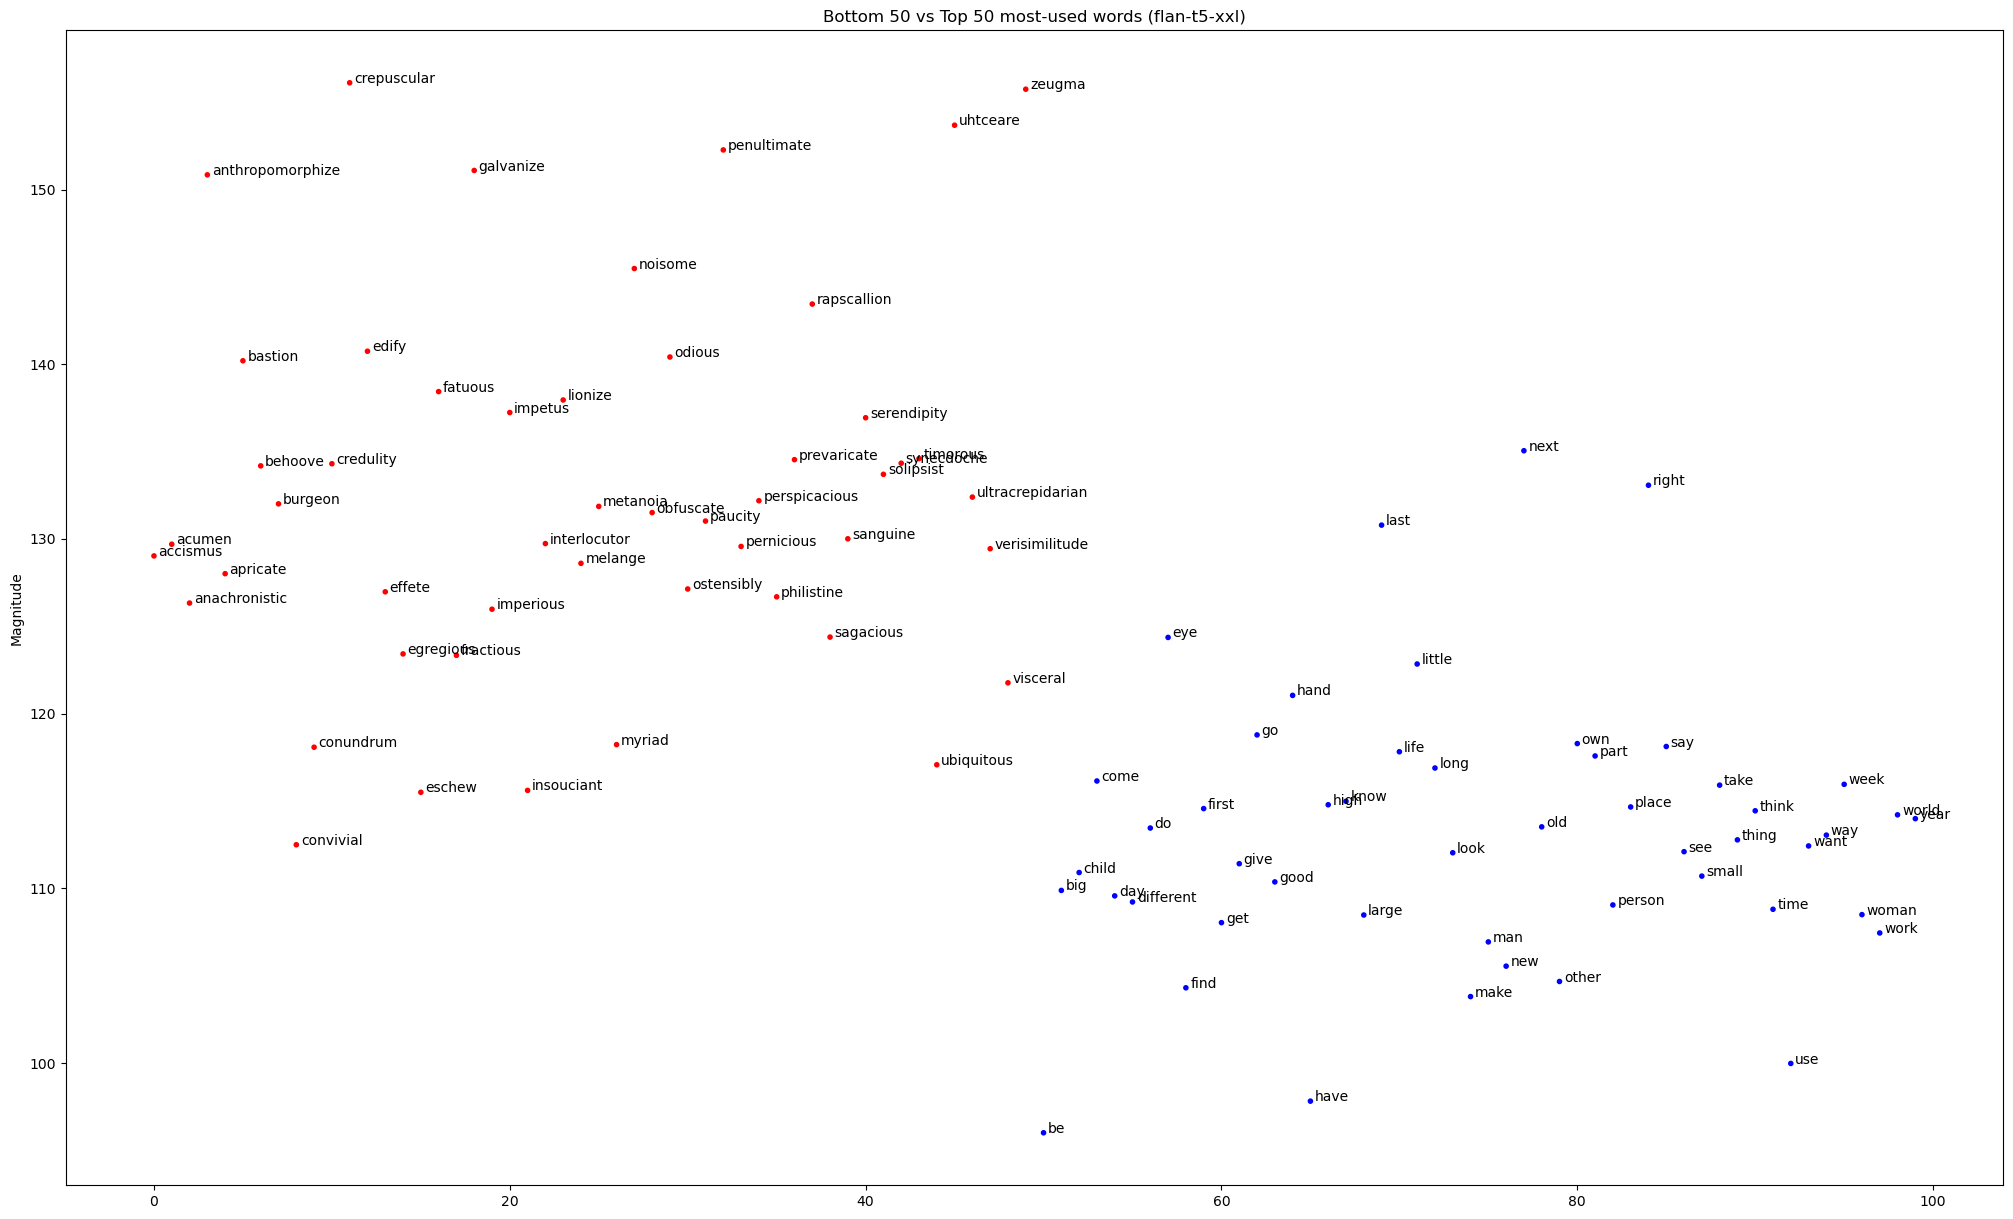

In [62]:
plt.figure(figsize=(25, 15))
plt.title('Bottom 50 vs Top 50 most-used words (flan-t5-xxl)')
plt.ylabel('Magnitude')
plt.scatter(range(100), Y_t5, c=colors, marker='.')
for i in range(0, 100):
    plt.annotate(X[i], (i+0.25, Y_t5[i]))

* Revisions

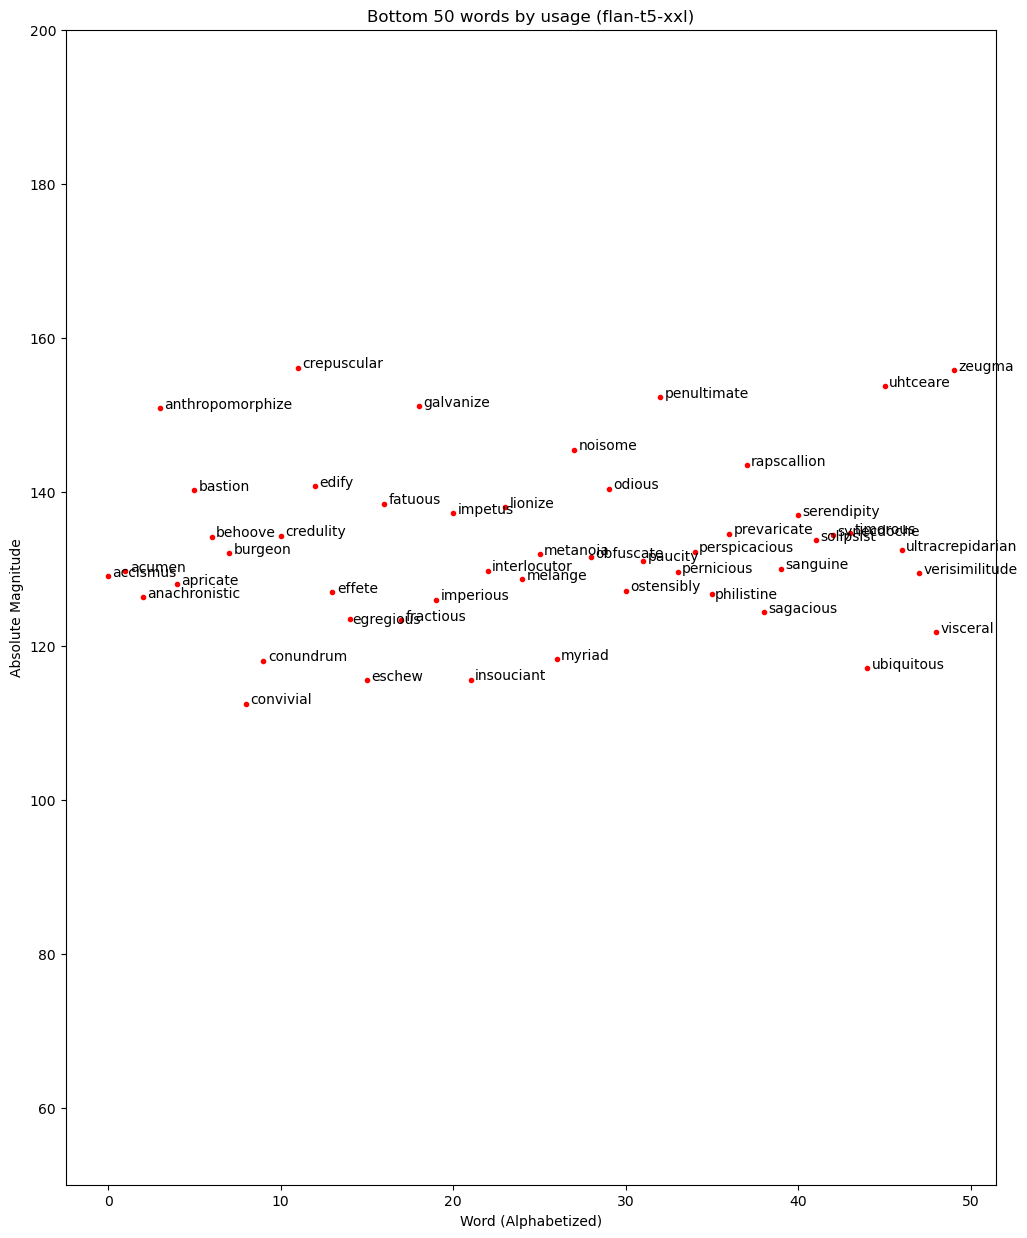

In [71]:
plt.figure(figsize=(12, 15))
plt.title('Bottom 50 words by usage (flan-t5-xxl)')
plt.ylabel('Absolute Magnitude')
plt.ylim((50, 200))
plt.xlabel('Word (Alphabetized)')
plt.scatter(range(50), Y_t5[:50], c='r', marker='.')

for i in range(50):
    if i in [14, 35]:
        plt.annotate(X[i], (i+0.15, Y_t5[i]-.5))
    else: plt.annotate(X[i], (i+0.25, Y_t5[i]))

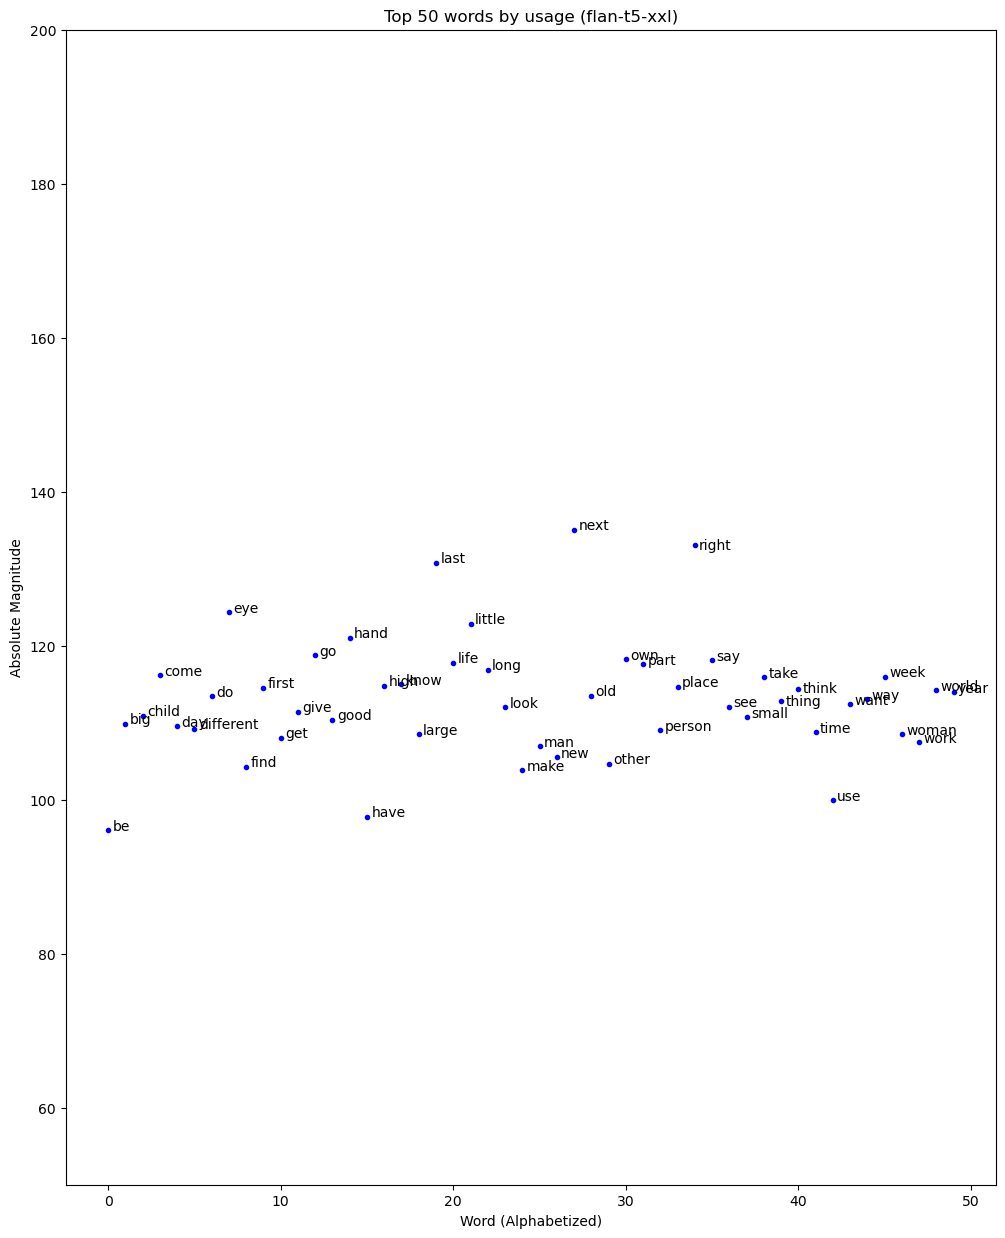

In [70]:
plt.figure(figsize=(12, 15))
plt.title('Top 50 words by usage (flan-t5-xxl)')
plt.ylabel('Absolute Magnitude')
plt.ylim((50, 200))
plt.xlabel('Word (Alphabetized)')
plt.scatter(range(50), Y_t5[50:], c='b', marker='.')

for i in range(50, 100):
    if (i-50) in [34, 39, 40]:
        plt.annotate(X[i], (i-50 + 0.25, Y_t5[i]-.5))
    else: plt.annotate(X[i], (i-50 + 0.25, Y_t5[i]))

* Computing averages across dictionary
    * average magnitude
    * median magnitude

In [65]:
from statistics import median, mean

In [66]:
X_vocab = []
Y_vocab_t5 = []
for word in vocab:
    X_vocab.append(word)
    Y_vocab_t5.append(sum_complexity(word, model='t5'))

In [67]:
print('|---------------------------------------------------------------------------------------------------------------|')
print(f'| Model\t\t| Mean (bot.)\t\t| Mean (top)\t\t| Median (bot.)\t\t| Median (top)\t\t|')
print(f'| T5-3B:\t| {mean(Y_t5[:50])}\t| {mean(Y_t5[50:])}\t| {median(Y_t5[:50])}\t| {median(Y_t5[50:])}\t|')
print(f'| Full Vocab:\t|\t\t{mean(Y_vocab_t5)}\t\t|\t\t{median(Y_vocab_t5)}\t\t|')
print('|---------------------------------------------------------------------------------------------------------------|')

|---------------------------------------------------------------------------------------------------------------|
| Model		| Mean (bot.)		| Mean (top)		| Median (bot.)		| Median (top)		|
| T5-3B:	| 132.686323617303	| 113.10065631617496	| 131.68614722731218	| 112.91106216745371	|
| Full Vocab:	|		118.01341761275407		|		116.68564676904626		|
|---------------------------------------------------------------------------------------------------------------|
